# Automa tutorial part 1
In bioinformatics, we have a saying:
>The first step of any bioinformatics project is to define a new file format, incompatible all previous ones.

The situation might not be *quite* as bad as the saying implies, but it *is* true that we have a *lot* of different file formats, representing the various kinds of data we work with.

For that reason, creating file parsers is a central task in bioinformatics, and has almost become [a craft in itself.](http://biopython.org/DIST/docs/tutorial/Tutorial.html#sec14) An awful, awful craft. For anything but the simplest formats, designing robust parsers is hard, and it is difficult to know if a parser you'be built is solid. Insignificant details like trailing whitespace can break a seemingly well-built parser.

At its core, a parser is a program that checks whether some input data comforms to some format. For bioinformatics, we typically also want to load the data in the file into some data structure to work on it. The format itself is typically specified in some kind of higher-level, but unambiguous language, like [this description of the Newick format.](https://en.wikipedia.org/wiki/Newick_format#Grammar) A parser then, can be viewed as a program that:

* Checks whether a file follows a specification phrased in a high-level "language", e.g. "a leaf in the Newick format consist of only a *name*, which is formed from the alphabet "a-z, A-Z and _"", and

* Checks whether some input follows that specification using relatively low-level instructions, e.g. checking whether the following bytes until the next `(`, `)`, `,` or `;` match the pattern `[A-Za-z_]`

The central job of a parser is then to act as a *translator* between different abstraction levels: The format is specified in a high-level language, but the actual data processing must happen at a lower level language.

When described like that, parser generation seems quite analogous to code compilation, and begins too look like a *machine's job*, not a human's. Machines are fast and accurate, and do not make oversights or mistakes - exactly the characteristics you want when making a parser. Let's leave the machine tasks to the machines; we humans ought to put our effort into what we do best: Specifying the formats themselves.

In this tutorial, I will introduce Automa, a Julia package for creating parsers. Actually, when reading this you might be able to tell that Automa solves a problem slightly more general than just creating parsers, but creating parsers is what we will use it for in this tutorial. Automa is not an easy package to use; it is complex and a little opaque, but it's worth all the effort and more. Parsers generated by Automa have several advantages over human-made parsers:

* They are failsafe: Any deviation of the input from the specified format, no matter how trivial, will cause it to fail. Therefore, they are much more reliant than human-written parsers.
* They are easy to change. You can often easily change details in the input format, such as allowing whitespace, with minimal changes to your code,
* They are quite fast, with Automa-code often being faster than even optimized human-crafted parsers.

In this first part of the tutorial I will show how to create parsers from data loaded into memory in order to highlight Automa itself. In the second part, which I will release at a later date, I will show how to create a proper BioJulia reader and writer for a file format.


## Our format

For our example, let us begin with a simlified version of the FASTA format - we can call it "SimpleFasta". Our format will be defined as something that looks like this:

    >first
    TGATAGTAGTCGTGTGATA
    >second
    AGGACCCAATTATCGGGGTAA
    
I.e.
* A SimpleFasta file is a sequence of zero or more *records*
* A *record* consists of *header* \* newline \* *sequence* \* newline, where "\*" signifies concatenation
* A *header* consists of `>` followed by one or more characters from the alphabet a-z
* A *sequence* consists of one or more chatacters from the alphabet A, C, G or T.

We can visualize a hypothetical SimpleFasta parser using a simple flowchart - note: You need to have `graphviz` installed to be able to run the code below.

In [1]:
s = """digraph {
graph [ rankdir = LR ];
begin [ shape = circle ];
begin -> header;
header [ shape = circle ];
header -> sequence;
sequence [ shape = circle ];
sequence -> end;
end [ shape = circle ];
sequence -> header;
begin -> end;
}
"""
function display_machine()
    write("/tmp/fasta_machine.dot", s)
    run(`dot -Tsvg -o /tmp/fasta_machine.svg /tmp/fasta_machine.dot`)
    open("/tmp/fasta_machine.svg") do file
        display("image/svg+xml", String(read(file)))
    end
end;

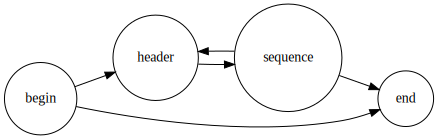

In [2]:
display_machine()

At the beginning of the file, we expect to see a header. Next, we move to the sequence of the header. From there, we can either reach the end of the file, or loop back to another header. Alternatively, in the case of an empty file, we may move from the beginning of the file to the end immediately without any headers or sequences. We consider an empty file to also be specification-compliant.

Note that this simple flowchart describes any *valid* SimpleFasta format. If, for example, a file had two consecutive header lines, there is no path we can take through the flowchart from "begin" to "end" which describes the file, and we can tell that the input did not conform to the format.

The circles marked "begin", "header", "sequence" or "end" are what we call the four *states*. Because the parser shown in the diagram has a fixed list of possible states that it changes between, we call the parser a *finite state machine* (FSM), or *finite state automaton* (FSA).

The flowchart above doesn't do a very good job of describing the FSM that our parser is, because it doesn't tell you *how* the machine transitions between states. The state *transitions* are what actually defines the format. For example, we know we are transitioning to a header when we see a `>` symbol.

In the flowchart below, the arrows signifying transitions between states are marked with the input character that causes the FSM (our parser) to transition, written in a regex-like notation. For example, the transition from a header to a sequence is defined by a `\n` followed by one of the characters in `[ACGT]`. "EOF" signifies end of file. Note also that some states have transitions leading to itself. For example, when in the "header" state, the FSM may continue to read characters in `a-z` and stay in the "header" state.

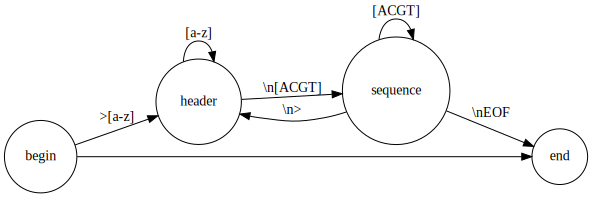

In [3]:
s = """digraph {
  graph [ rankdir = LR ];
begin [ shape = circle ];
header [ shape = circle ];
sequence [ shape = circle ];
end [ shape = circle ];

begin -> header [ label = ">[a-z]" ];
header -> header [ label = "[a-z]"]; 
header -> sequence [ label = "\\\\n[ACGT]" ];
sequence -> sequence [ label = "[ACGT]" ];
sequence -> header [ label = "\\\\n>" ];
sequence -> end [ label = "\\\\nEOF" ];
begin -> end;
}
"""
display_machine()

How does the machine know when it's supposed to transition between states? Suppose a machine is at the beginning of a file and it begins by observing the input `>`. Is this part of a transition to the header state, or the beginning of a malformed input?

It is certainly possible for the machine to have a *memory* of the pattern, such that it only transitions to the "header" state once it sees the two specific inputs `>` and `[a-z]` in that order. However, we can make things much simpler by requiring the machine to make a state transition for *every single input byte*, then we don't need any memory other than what state the machine is in, which is a single integer. To still represent the same format at the flowchart above, we need to insert some extra states:

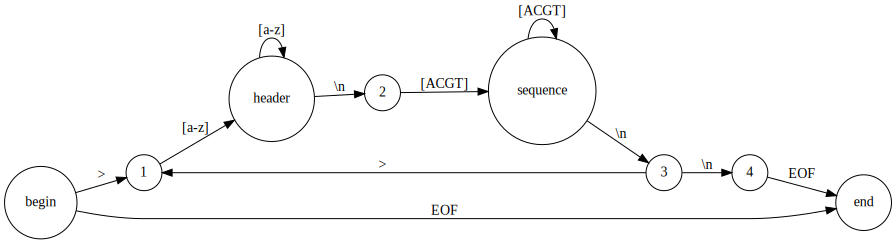

In [4]:
s = """digraph {
  graph [ rankdir = LR ];
  begin [ shape = circle ];
  2 [ shape = circle ];
1 [ shape = circle ];
3 [ shape = circle ];
  begin -> 1 [ label = ">" ];
  header [ shape = circle ];
1 -> header [label = "[a-z]" ];
header -> header [ label = "[a-z]" ];
2 -> sequence [ label = "[ACGT]" ];
header -> 2 [ label = "\\\\n" ];


sequence [ shape = circle ];
sequence -> sequence [ label = "[ACGT]" ];
sequence -> 3 [ label = "\\\\n" ];
3 -> 1 [ label = ">" ];
end [ shape = circle ];
4 [ shape = circle ];
3 -> 4 [ label = "\\\\n"]; 
4 -> end [ label = "EOF" ];
"begin" -> end [ label = "EOF" ];
}
"""
display_machine()

The diagram above is exactly equivalent to the previous one, but this diagram makes a state transition for *every single* input byte. All bytes cause a transition, and no transition consumes multiple bytes. For simplicity, Automa's parsers work like that.

Note that it is always possible, given a FSM with multi-byte transitions to convert it to a FSM with single-byte transitions by just putting in more nodes. E.g. the transition from header to sequence requires two bytes, a newline and an A, C, G or T. Therefore, an intermediate note (on the illustration marked "2") is needed. Unfortunately, the requirement of single-byte transitions limits what you can do with Automa - I'll come back to the limitations later.

Now let's create this same FSM using Automa.

In [5]:
# First imports
import Automa
import Automa.RegExp: @re_str
const re = Automa.RegExp;

We define the elements that make up the SimpleFasta using `Automa.RegExp`, a subset of regular expressions.
Automa's regular expressions can be manipulated with the following operations:

| Function           | Alias  | Meaning                  |
| --------           | ------ | -------                  |
| `cat(re...)`       | `*`    | concatenation            |
| `alt(re1, re2...)` | `\|`   | alternation              |
| `rep(re)`          |        | zero or more repetition  |
| `rep1(re)`         |        | one or more repetition   |
| `opt(re)`          |        | zero or one repetition   |
| `isec(re1, re2)`   | `&`    | intersection             |
| `diff(re1, re2)`   | `\`    | difference (subtraction) |
| `neg(re)`          | `!`    | negation                 |

Furthermore inside the re-strings themselves, you can use
* groups of characters, like `[ACGT]` representing the set `{A, C, G, T}`
* ranges `A-Z` representing `'A':'Z'` (or more accurately, the *bytes* `UInt8('A'):UInt8('Z')`
* `*`, representing zero or more repetitions of the last element, such as `[a-z]*`
* `+`, representing one or more repetitions of the last element, such as `[a-z]+`
* `?`, representing zero or one repetition of the last element, such as `[a-z]?`

In [6]:
machine = let
    # Define SimpleFasta syntax
    header = re">[a-z]+"
    sequence = re"[ACGT]+"
    record = header * re"\n" * sequence * re"\n"
    fasta = re.rep(record)

    Automa.compile(fasta)
end;

If you have `dot` installed on your computer, you can visualize the compiled FSM. You might want to modify the paths in the function below to make it work on your computer.

In [7]:
function display_machine(machine)
    write("/tmp/fasta_machine.dot", Automa.machine2dot(machine))
    run(`dot -Tsvg -o /tmp/fasta_machine.svg /tmp/fasta_machine.dot`)
    open("/tmp/fasta_machine.svg") do file
        display("image/svg+xml", String(read(file)))
    end
end;

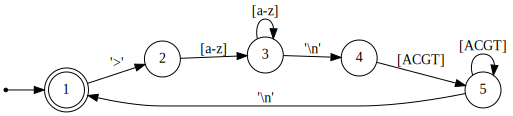

In [8]:
display_machine(machine)

Yes, that looks correct!
The start node here is the small point on the left. You can see one of the states are represented by a double circle. This represents an *accept state*, where the machine may stop at a valid end of input - here after each SimpleFasta record. If the machine stops at any other state, it did not complete correctly. In other words, state "1" here doubles as the "end" state.

With this parser we can read a SimpleFasta file and determine if it conforms to the specification. But that's not too useful. Normally, we parse a file in order to load it into some kind of datastructure.

Automa allows arbitrary Julia code to be executed at state transitions. We do that below. After defining the SimpleFasta syntax, we can add a list of action names (symbols) to each state. Later, we bind Julia code to the symbols. 

In [9]:
machine = let
    # Define SimpleFasta syntax
    newline = re"\n"
    header = re">[a-z]+"
    sequence = re"[ACGT]+"
    record = header * newline * sequence * newline
    fasta = re.rep(record)
        
    # Define SimpleFasta actions. We will define what these actions
    # actually DO at a later step.
    header.actions[:enter] = [:enter]
    header.actions[:exit] = [:exit_header]
    sequence.actions[:enter] = [:enter]
    sequence.actions[:exit] = [:exit_sequence]
    record.actions[:exit] = [:exit_record]

    Automa.compile(fasta)
end;

If we visualize the machine now, the actions will be printed on the relevant edges in the FSM diagram. For example, the newline after a header is labeled `'\n'/exit_header`, meaning the transition will happen at the input byte `'\n'`, and it will execute the action `exit_header`.

Also note that the diagram structure itself changed, because the entering state and exit state are now distinct. The exit state 6 will execute `:exit_record` at the end of file (EOF), whereas if the FSM ends at state 1, `:exit_record` is not executed. 

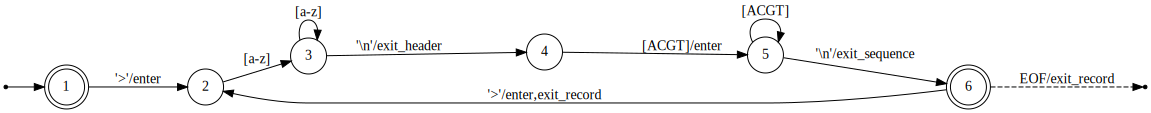

In [10]:
display_machine(machine)

Let's also define a simple data structure to parse the SimpleFasta records into. Like our SimpleFasta format, let's not overcomplicate things:

In [11]:
using BioSequences

In [12]:
struct FastaRecord{A}
    header::String
    sequence::LongSequence{A}
end

FastaRecord(h, sequence::LongSequence{A}) where A = FastaRecord{A}(h, sequence);

Now we need to tell Automa what code each of these actions refer to *mean*. So, we create a `Dict{Symbol,Expression}` that maps the action names to Julia code. When the action named by the symbol is encountered in our FSM, it will execute the code contained in the expression.

A few remarks about the code below so it makes sense:
* Automa reads in the data as an `AbstractVector{UInt8}`, that is, a byte vector. Automa calls this vector `data` in Automa's generated code, so I can use that name without defining it first.
* The current index into `data` that points to the byte currently being parsed by Automa is called `p`, and the byte itself is called `byte`.
* The current state of the FSM is stored in an integer called `cs` we can access. We will use that later.

In [13]:
actions = Dict(
    # Record which byte position marks the beginning of header or sequence
    :enter => quote
        mark = p
    end,
    :exit_header => quote
        header = String(data[mark+1:p-1])
    end,
    :exit_sequence => quote
        sequence = LongSequence{A}(data[mark:p-1])
    end,
    :exit_record => quote
        record = FastaRecord(header, sequence)
        push!(records, record)
    end,
);

We also need to specify a `CodeGenContext` where we can customize how Automa will create its code. For now, let's not worry about that and just use the default options to create code:

In [14]:
context = Automa.CodeGenContext();

Now we can create the parser code and evaluate it. First, we define the variables used in the parser code we specified in the `actions` dictionary. Then we splice in the initalizing code of Automa where things like `data` and `p` are defined. We also need to manually specify `p_end` and `p_eof` - these variables specify where the input data ends. I will discuss those in more detail in the second part of this tutorial where I show how to create parsers for data we stream into memory. For now just set it to the end of the input vector. Then we add the execution code. Last, we check if the FSM exited properly - we do that by checking if its state is the zero state.

In [15]:
@eval function parse_fasta(::Type{A}, data::Union{String,Vector{UInt8}}) where {A <: Alphabet}
    # We can't control the order the code from `actions` is executed, so
    # we define variables beforehand so we are sure they are not used before
    # they are defined.
    mark = 0
    records = FastaRecord{A}[]
    header = ""
    sequence = LongSequence{A}()

    $(Automa.generate_init_code(context, machine))
    p_end = p_eof = lastindex(data)
    $(Automa.generate_exec_code(context, machine, actions))

    # If the FSM stopped at an accept state, cs will be zero. If it's not zero,
    # we know the input was malformed.
    iszero(cs) || error("failed to parse on byte ", p)
    return records
end;

We can verify that it works:

In [16]:
parse_fasta(DNAAlphabet{4}, ">hello\nTAG\n>there\nTAA\n")

2-element Array{FastaRecord{DNAAlphabet{4}},1}:
 FastaRecord{DNAAlphabet{4}}("hello", TAG)
 FastaRecord{DNAAlphabet{4}}("there", TAA)

And that if the format does not follow specification at even a single byte, it will fail. For example, if we have trailing whitespace:

In [17]:
parse_fasta(DNAAlphabet{4}, ">hello\nTAG\n>there\nTAA\n   ")

LoadError: failed to parse on byte 23

## Redesign the format
With the basics now covered, let's step up the game a tad and make it parse SimpleFasta records with multiple lines per sequence. We first define a `seqline` pattern that looks like the old `sequence` pattern, and build a new `sequence` pattern from multiple `seqline` patterns.

In [18]:
machine = let
    # Define SimpleFasta syntax
    header = re">[a-z]+"
    seqline = re"[ACGT]+"
    sequence = seqline * re.rep(re"\n" * seqline)
    record = header * re"\n" * sequence * re"\n"
    fasta = re.rep(record)
        
    # Define SimpleFasta actions
    header.actions[:enter] = [:enter]
    header.actions[:exit] = [:exit_header]
    seqline.actions[:enter] = [:enter]
    seqline.actions[:exit] = [:exit_seqline]
    record.actions[:exit] = [:exit_record]

    Automa.compile(fasta)
end;

The machine now has a subtle change with a small loop between node 5 and 6 representing the parser seeing multiple sequence lines.

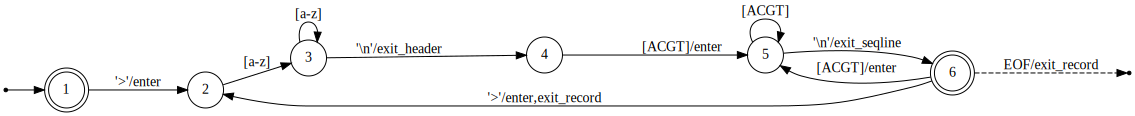

In [19]:
display_machine(machine)

We also need to update the `actions`. Here, I use `:(this syntax)`, which is equivalent to
```
quote 
    this syntax
end
```
but more readable for one-liners. I keep a buffer containing the sequence, and append every sequence line to the buffer at the end of each `seqline`. When the record is done, I create the sequence and empty the buffer for the next record.

In [20]:
actions = Dict(
    :enter => :(mark= p),
    :exit_header => :(header = String(data[mark+1:p-1])),
    :exit_seqline => quote
        doff = length(seqbuffer) + 1
        resize!(seqbuffer, length(seqbuffer) + p - mark)
        copyto!(seqbuffer, doff, data, mark, p-mark)
    end,
    :exit_record => quote
        sequence = LongSequence{A}(seqbuffer)
        empty!(seqbuffer)
        record = FastaRecord(header, sequence)
        push!(records, record)
    end,
);

We need to redefine `parse_fasta`, now also containing the `seqbuffer`:

In [21]:
@eval function parse_fasta(::Type{A}, data::Union{String,Vector{UInt8}}) where {A <: Alphabet}
    mark = 0
    records = FastaRecord{A}[]
    header = ""
    sequence = LongSequence{A}()
    seqbuffer = UInt8[]

    $(Automa.generate_init_code(context, machine))
    p_end = p_eof = lastindex(data)
    $(Automa.generate_exec_code(context, machine, actions))

    iszero(cs) || error("failed to parse on byte ", p)
    return records
end;

And we can confirm it now works for multiple sequences!

In [22]:
parse_fasta(DNAAlphabet{2}, ">hello\nTAG\nGGG\n>there\nTAA\nTAG\n")

2-element Array{FastaRecord{DNAAlphabet{2}},1}:
 FastaRecord{DNAAlphabet{2}}("hello", TAGGGG)
 FastaRecord{DNAAlphabet{2}}("there", TAATAG)

## Even more complexity

One of the greatest things about Automa is how we can parse quite complicated formats without needing to manually construct much code. For example, here, I change *only* the regular expressions:
* I allow optional Windows-style newlines (`\r\n`)
* I allow trailing whitespace on each line (`re.space() \ (re"\r" | re"\n")` means all space characters except \r or \n), but not whitespace inside headers
* Sequences can only contain all UIPAC ambiguous RNA or DNA nucleotides
* The trailing record no longer needs a trailing newline to be valid. It has the same actions as a regular record.

In [23]:
machine = let
    # Define FASTA syntax
    newline = re.opt("\r") * re"\n"
    hspace = re.space() \ (re"\r" | re"\n")
    header = re">" * re.rep1((re.any() \ re.space())) * re.opt(hspace)
    seqline = re"[acgturmkyswbdhvnACGTURMKYSWBDHVN\-*]+" * re.opt(hspace)
    sequence = seqline * re.rep(newline * seqline)
    record = header * newline * sequence * newline
    trailing_record = header * newline * sequence * re.rep(newline * re.opt(hspace))
    fasta = re.rep(newline) * re.rep(record) * re.opt(trailing_record)
        
    # Define FASTA actions
    header.actions[:enter] = [:enter]
    header.actions[:exit] = [:exit_header]
    seqline.actions[:enter] = [:enter]
    seqline.actions[:exit] = [:exit_seqline]
    record.actions[:exit] = [:exit_record]
    trailing_record.actions[:exit] = [:exit_record]

    Automa.compile(fasta)
end;

The machine is now a bit more complicated. But who cares, it's automatically generated. Look how easy it was to generate!

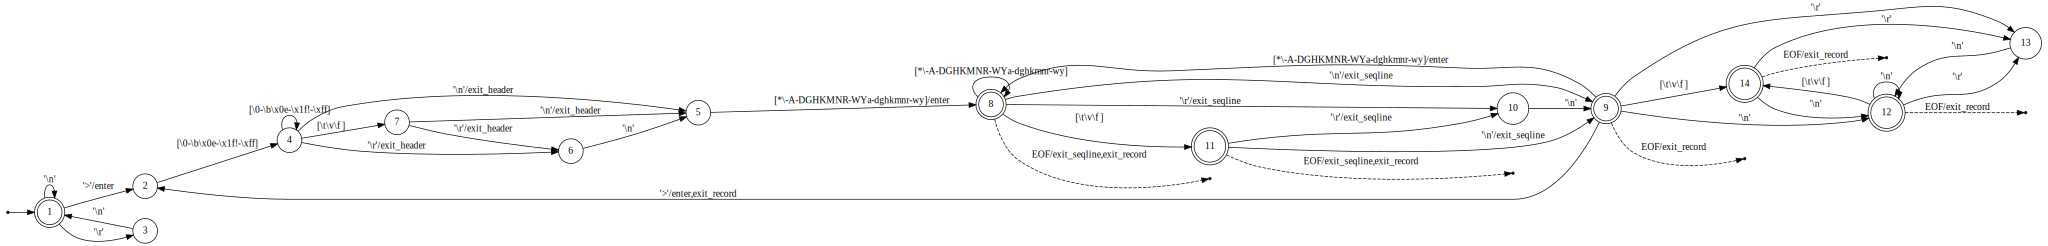

In [24]:
display_machine(machine)

## Optimizing

Automa's parsers are pretty fast. To create hand-written parsers of comparable speeds, you need to microoptimize every operation, which is annoying. That being said, for actually loading parsed files to be fast, you need to optimize the user-defined actions in the actions dictionary, too.

How fast is our un-optimized Fasta parser already? Let's test it on some data and find out. I'll make 50k sequences with 2k base pairs each, for a total of 100 MB data.

Remember to re-run the block of code where the `parse_fasta` function is defined since we changed the machine.

In [25]:
# Create 50k records with 2kbp each
function generate_data()
    open("/tmp/fasta.fna", "w") do file
        for seq in 1:50000
            println(file, '>', join(rand('a':'z', 16)))
            for line in 1:20
                println(file, join(rand("ACGT", 100)))
            end
        end
    end
end
generate_data()

In [26]:
function parsedata()
    open("/tmp/fasta.fna") do file
        parse_fasta(DNAAlphabet{2}, read(file))
    end
end;

In [27]:
@time parsedata();

  0.353571 seconds (300.04 k allocations: 169.378 MiB, 3.51% gc time)


Alright! It does about 250 MB/s on my laptop. Not bad! I'd say for most applications, this speed is more than sufficient.

But this is Julia. We want to be able to optimize the crap out of it. So let's optimize the actions:

In [28]:
actions = Dict(
    :enter => :(mark = p),
    
    # Create string with only one copy of the data.
    :exit_header => :(header = unsafe_string(pointer(data, p), p - mark + 1)),
    
    # Only resize buffer if it's too small, else just keep track of how many bytes are used.
    :exit_seqline => quote
        N = p - mark
        length(seqbuffer) < filled + N && resize!(seqbuffer, filled + N)
        copyto!(seqbuffer, filled+1, data, mark, N)
        filled += N
    end,
    
    # Use `copyto!` to only encode data directly from data vector into sequence
    # note this requires the latest versions of BioSequences.
    :exit_record => quote
        sequence = copyto!(LongSequence{A}(filled), 1, seqbuffer, 1, filled)
        record = FastaRecord(header, sequence)
        push!(records, record)
        filled = 0
    end,
);

If we want to optimize, we also need to use the fastest `CodeGenContext`. We use the `:goto`-generator. This creates machine code using `@goto`-statements, which creates very long and completely unreadable code - but it's fast. Also, who cares if it's hard to read. It's machine-generated code. We disable the FSM's boundschecks when accessing the `data` vector - since we don't manipulate the position `p` manually, we are confident it will not go out of bounds. And we allow the code generator to unroll loops:

In [29]:
context = Automa.CodeGenContext(generator=:goto, checkbounds=false, loopunroll=4);

We also need to modify the `parse` function because we use a new variable called `filled` and need to initialize it.

In [30]:
@eval function parse_fasta(::Type{A}, data::Union{String,Vector{UInt8}}) where {A <: Alphabet}
    mark = 0
    records = FastaRecord{A}[]
    header = ""
    sequence = LongSequence{A}()
    seqbuffer = UInt8[]
    filled = 0

    $(Automa.generate_init_code(context, machine))
    p_end = p_eof = lastindex(data)
    $(Automa.generate_exec_code(context, machine, actions))

    iszero(cs) || error("failed to parse on byte ", p)
    return records
end;

In [31]:
@time parsedata();

  0.243418 seconds (250.04 k allocations: 164.038 MiB, 28.85% gc time)


Okay, we're at slightly above 500 MB/s. Profiling confirms nearly all time is spent encoding the DNA sequences to `LongSequence`. We can make it faster still by not storing the data as a `LongSequence`, and instead make it a "lazy" object that only constructs the sequence upon demand. Even further, we could avoid heap-allocating each sequence individually. But these optimizations do not pertain directly to Automa, and I will leave them here.

## Pitfall 1: Ambiguous parsers

Besides its complexity, building parsers with Automa has some pitfalls - notably those caused by Automa transitioning state for every input byte.

Unfortunately, it's very easy to accidentally create a machine that can't possibly figure out what action to take when looking only at one byte at a time:

In [32]:
machine = let
    left = re"Turn left!"
    right = re"Turn right!"
    left_or_right = left | right
    
    left.actions[:enter] = [:turn_left]
    right.actions[:enter] = [:turn_right]
    
    Automa.compile(left_or_right)
end

Automa.Machine(<states=1:14,start_state=1,final_states=Automa.StableSet{Int64}(Automa.StableDict(13 => nothing))>)

Automa refuse to create this FSM. Why? Well, the first byte it expects is a `T` - but there is no way of knowing whether it's entering `left` or `right` when it sees that byte, and these two patters have conflicting actions! If they had the same actions, there would be no problem.

This situation is highly artificial, but the situation happens often in real life. Here's a very subtle change to one of the previous parsers:

In [33]:
machine = let
    # Define SimpleFasta syntax
    header = re">[a-z]+"
    seqline = re"[ACGT]+"
    sequence = seqline * re.rep(re"\n" * seqline)
    record = header * re"\n" * sequence
    fasta = re.rep(record * re"\n")
        
    # Define SimpleFasta actions
    header.actions[:enter] = [:enter]
    header.actions[:exit] = [:exit_header]
    seqline.actions[:enter] = [:enter]
    seqline.actions[:exit] = [:exit_seqline]
    record.actions[:exit] = [:exit_record]

    Automa.compile(fasta)
end;

After a `seqline`, when encountering a newline, there is no way of knowing whether this marks the end of a record or whether it continues at the next line. Automa can't look ahead, it has to make a decision at every byte.

Here, the solution is to move the newline from the definition of `fasta` to that of `sequence`. That way, the newline functions as a kind of one-byte lookahead - if the byte after the newline is a `>`, it knows the record is complete.

In general, encountering situations like this is usually a sign that the parser is badly built - or that the format is. You can usually resolve it by using single-byte lookahead like above. If not, it is possible to optionally disable the check for ambiguous actions by passing a keyword to the `Automa.parse` function. But beware that this may lead to absurd results.

## Pitfall 2: No recursively defined patterns

Some formats are naturally recursive. The [Newick format](https://en.wikipedia.org/wiki/Newick_format), for example, defines "subtree" in terms of "internal", which is defined in terms of "branchset", defined in terms of "branch" which is defined in terms of... "subtree".

Something like that will not work Automa:

In [34]:
simple_newick = let
    name = re"[a-z_]"
    clade = name | (re"\(" * cladeset * ")")
    cladeset = clade * re.rep(re"," * clade)
    Automa.compile(cladeset * re";")
end
    

LoadError: UndefVarError: cladeset not defined

Because, in general, you can't refer to objects in Julia that have not yet been defined. Worse, even if the syntactical challenge was solved, recursive patterns usually only make sense if you have lookahead. Newick files, for example, simply *can't* be parsed by FSMs, because every time you see an open parenthesis, you need to make sure there is a closing one further in the file, and this requires lookahead that can't be resolved by parsing one byte at a time.

Luckily, because Automa can execute arbitrary Julia code, we can have the FSM manipulate a stack and turn the FSM into a *pushdown automaton*, which can handle formats like Newick. It does require a little more manual fiddling, and is less elegant:

In [35]:
machine = let
    name = re"[a-z_]+"
    cladestart = re"\("
    cladestop = re"\)"
    cladesep = re","
    nodechange = cladestart | cladestop | cladesep
    newick_element = nodechange * re.opt(name)
    tree = re.opt(name) * re.rep(newick_element) * re";"
    
    cladestart.actions[:enter] = [:push]
    cladestop.actions[:enter] = [:pop]
    cladesep.actions[:enter] = [:pop, :push]
    
    Automa.compile(tree)
end 

actions = Dict(
    :push => quote
        level -= 1
    end,
    :pop => quote
        iszero(level) && error("Too many closing parentheses")
        level += 1
    end
);

In [36]:
@eval function parse_newick(data::Union{String,Vector{UInt8}})
    level = 0
    $(Automa.generate_init_code(context, machine))
    p_end = p_eof = lastindex(data)
    $(Automa.generate_exec_code(context, machine, actions))

    iszero(cs) || error("failed to parse on byte ", p)
    iszero(level) || error("Too many opening parentheses")
end;

And it sort of works:

In [37]:
println("Does this parse? ", parse_newick("(hello,hi);"))
println("Does this parse? ", parse_newick("(hello,hi)(;"))

Does this parse? true


LoadError: Too many opening parentheses

Here, I needed to manually keep track of the level of nesting. In fact, I would have to keep track of more stuff to disallow inputs like `();`, removing some of the point of Automa - namely, that it is automatic.

In the next part of this tutorial, I will show how to use Automa to create honest-to-God parsers which integrate with the BioJulia ecosystem and can work on streamed data.